In [7]:
import pandas as pd
from tmotifs import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# UoC - IRVINE Social Media Dataset

This example uses a temporal network from the University of California Irvine.

To follow along with running this notebook, the data can be downloaded [here](https://snap.stanford.edu/data/CollegeMsg.html).

Alternatively you can use your own data.

In [4]:
data = pd.read_csv('./messages.txt',
                   sep=' ',
                   header=None, 
                   names=['source', 'target', 'time'],
                   parse_dates=[2],
                  )

data.time = data.time.astype(int)
data['timestamp'] = pd.to_datetime(data.time, unit='s', utc=False)
data.time = data.time - data.time[0]

In [5]:
data.head()

,source,target,time,timestamp
0,1,2,0,2004-04-15 14:56:01
1,3,4,114878,2004-04-16 22:50:39
2,5,2,373430,2004-04-19 22:39:51
3,6,7,398658,2004-04-20 05:40:19
4,8,7,398795,2004-04-20 05:42:36


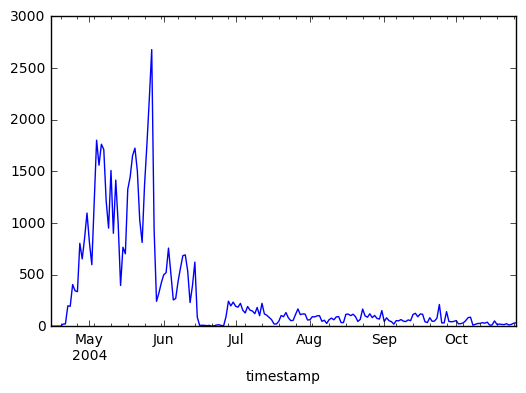

In [8]:
# Activity over time
data.set_index(['timestamp']).groupby(pd.TimeGrouper('D')).size().plot();

### TEG

In [9]:
teg = EventGraph.from_eventlist(data)
teg.build(verbose=True)

/localhome/users/mmasm/anaconda/envs/python3/lib/python3.4/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/localhome/users/mmasm/anaconda/envs/python3/lib/python3.4/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


 59800/59835

In [10]:
teg.add_edge_types(verbose=True, columns=['source', 'target', 'time'])

 100102/100103

In [6]:
teg.save('./california-irvine-teg.pkl')

This now saves the TEG as as pickle incase we want to use it later.

We can load in a pickle file using the inbuilt function.

In [2]:
teg = EventGraph.from_pickle('./california-irvine-teg.pkl')

## TEG Analysis

In [351]:
teg_components = sorted(nx.weakly_connected_component_subgraphs(teg), 
                                 key=len, 
                                 reverse=True)

or we can equivalently use the in-build property

In [18]:
teg_components = teg.maximal_subgraphs

In [22]:
# The components are ranked in order, largest first.
gcc = teg_components[0] # Giant Connected Component.
gcc.event_list = teg.event_list

### Temporal Barcodes

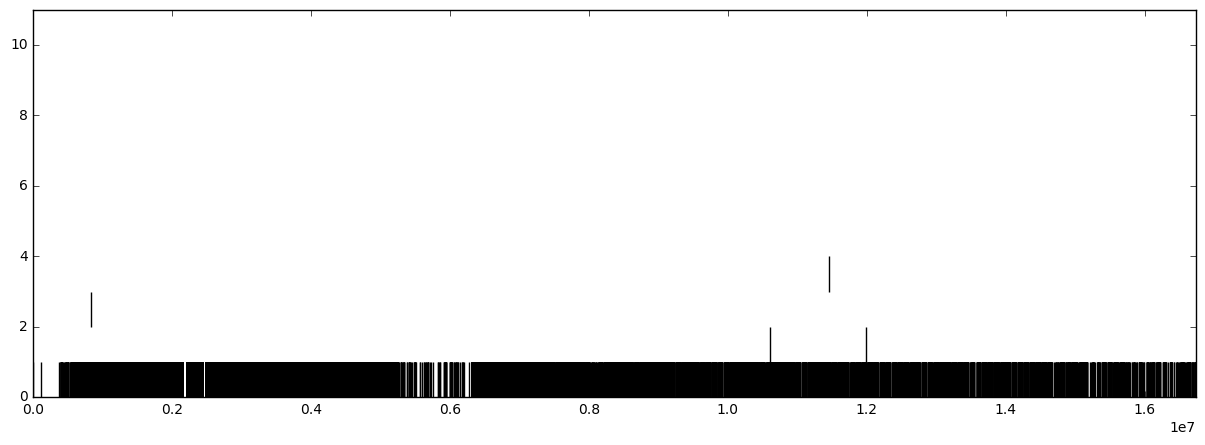

In [11]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
plot_full_barcode_efficiently(teg, dt=1e9, top=10, ax=ax) # Dt = Infinity

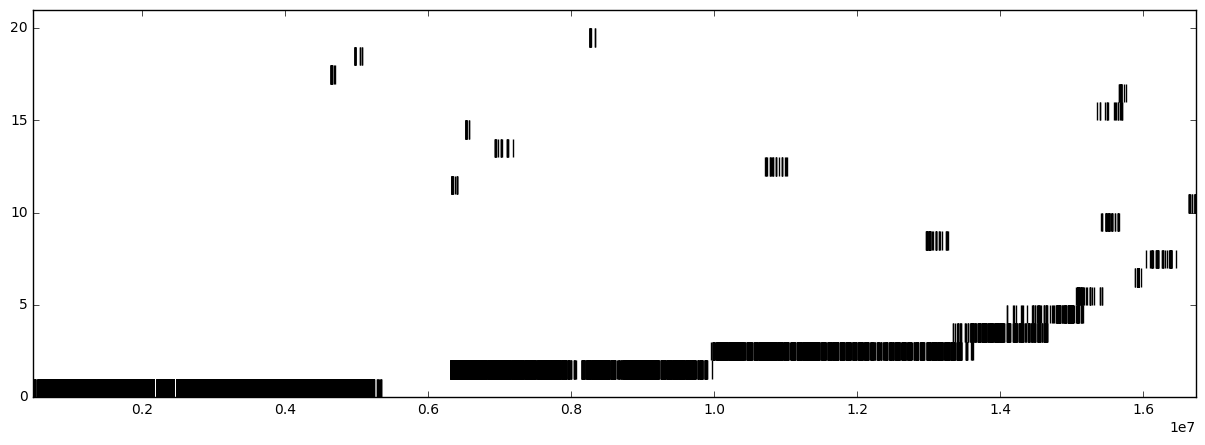

In [24]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
plot_full_barcode_efficiently(teg, dt=86400, top=20, ax=ax) # Dt = 1 day (in seconds)

#### Decomposition

We can filter the TEG by removing edges which are longer than a value $\Delta t$

In [28]:
hour_teg = teg.filter_edges(dt=3600)

This behaves exactly like the TEG does, although now its component structure will differ.

We can also subsample our TEG by looking at a time window (this is because we have the timestamp column in our data, we can also just filter the data using the time column).

In [29]:
start_date = pd.to_datetime('2004-05-10 00:00:00')
end_date = pd.to_datetime('2004-05-11 00:00:00')

condition = (teg.event_list.timestamp < end_date) & (teg.event_list.timestamp > start_date)
subnodes = teg.event_list[condition].index

subteg = teg.subgraph(subnodes)
subteg.event_list = teg.event_list[condition]

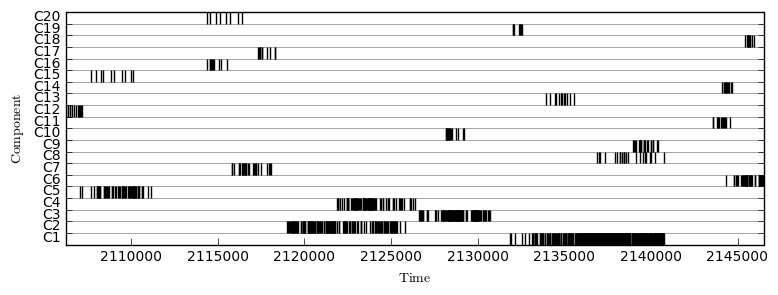

In [31]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(9,3))
plot_fancy_barcode(subteg, dt=600, top=20, ax=ax) # The fancy barcode functions exactly the same, although has better clearer labelling.

ax.set_xlabel(r'${\rm Time}$')
ax.set_ylabel(r'${\rm Component}$')

### Network Structural Dependence on $\Delta t$

In [32]:
# Calculating the size of the largest component for different values of Dt.

dts = np.linspace(0, 86400, 50) # Range of DT we want to explore
summary = {}

for ix, dt in enumerate(dts):
    print(ix, end=',')
    d = {}
    filtered = teg.filter_edges(dt) 
    
    comps = [x for x in nx.weakly_connected_components(filtered)]
    d['num_components'] = len(comps)
    
    event_sizes = [len(x) for x in comps]
    d['largest_component'] = max(event_sizes)
    d['mean_component'] = mean(event_sizes)
    d['events'] = len(teg)
    summary[dt] = d
summary = pd.DataFrame(summary).T

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,

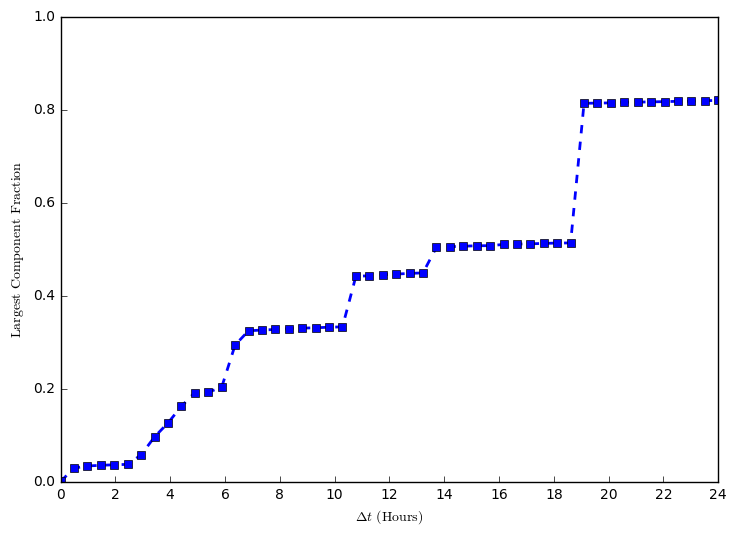

In [33]:
fig = plt.figure(figsize=(6*np.sqrt(2),6))
ax = fig.add_subplot(111)

y = summary.largest_component/summary.events
y.index = y.index/3600

y.plot(ax=ax, marker='s', linewidth=2, linestyle='--')

ax.set_ylim((0,1))

ax.set_xticks(np.arange(0,25,2))

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.set_xlabel(r"$\Delta t$ $(\rm Hours)$" )
ax.set_ylabel(r"$\rm Largest$ $\rm Component$ $\rm Fraction$" )

In [35]:
# Calculating the component size distribution.

from collections import defaultdict

dists = {}
dts = [60, 3600, 86400]

def get_component_sizes(teg, dt):
    """ Retrieves the sizes of all components for a given TEG and value of Dt. """
    data = [len(x) for x in nx.weakly_connected_component_subgraphs(teg.filter_edges(dt))]
    return data

for t in dts:
    sizes = get_component_sizes(teg, t)
    dists[t] = sizes

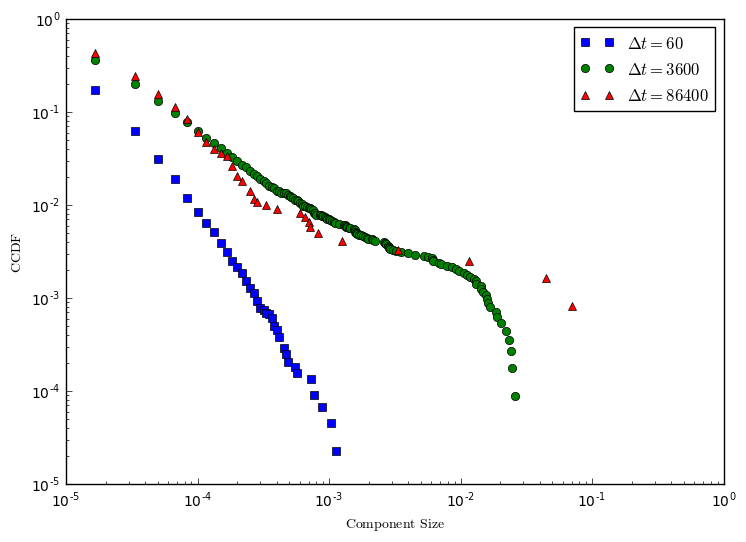

In [39]:
from itertools import cycle
markers = ['s', 'o', '^', 'v', '<', '>']
markers = cycle(markers)

fig = plt.figure(figsize=(6*np.sqrt(2),6))
ax = fig.add_subplot(111)

for key, val in pd.Series(dists).sort_index().items():
    if key not in [60, 3600, 86400]:
        continue
    maximum = len(teg)
    val = [x/maximum for x in val]
    ccdf = get_ccdf(val)
    ccdf.plot(ax=ax, logx=True, logy=True, label=r"$\Delta t = {}$".format(key), marker=next(markers), linestyle='', )

ax.legend(loc='best')   
ax.set_ylabel(r'$\rm CCDF$')
ax.set_xlabel(r'$\rm Component$ $\rm Size$')
ax.set_xlim((1e-5, 1))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

### Motifs

Motifs are calculated using the teg.get_motif_distribution() function.

This also works on any temporal components (as they are also encoded as TEGs themselves).

In [42]:
from collections import Counter

components = hour_teg.maximal_subgraphs

storage = {}
for ix, component in enumerate(components):
    storage[ix] = Counter(component.get_motif_distribution())
    
motifs = pd.DataFrame.from_dict(storage).fillna(0).T
motifs = motifs.div(motifs.sum(axis=1), axis=0).dropna()

In [43]:
motifs.head()

,AB-AB,AB-AC,AB-BA,AB-BC,AB-CA,AB-CB
0,0.102307,0.276883,0.162386,0.097519,0.148890,0.212016
1,0.104575,0.298475,0.115468,0.104031,0.157952,0.219499
2,0.084229,0.335723,0.113501,0.096177,0.147551,0.222820
3,0.055490,0.281582,0.178276,0.122786,0.168241,0.193625
4,0.076161,0.277399,0.133746,0.143034,0.151084,0.218576


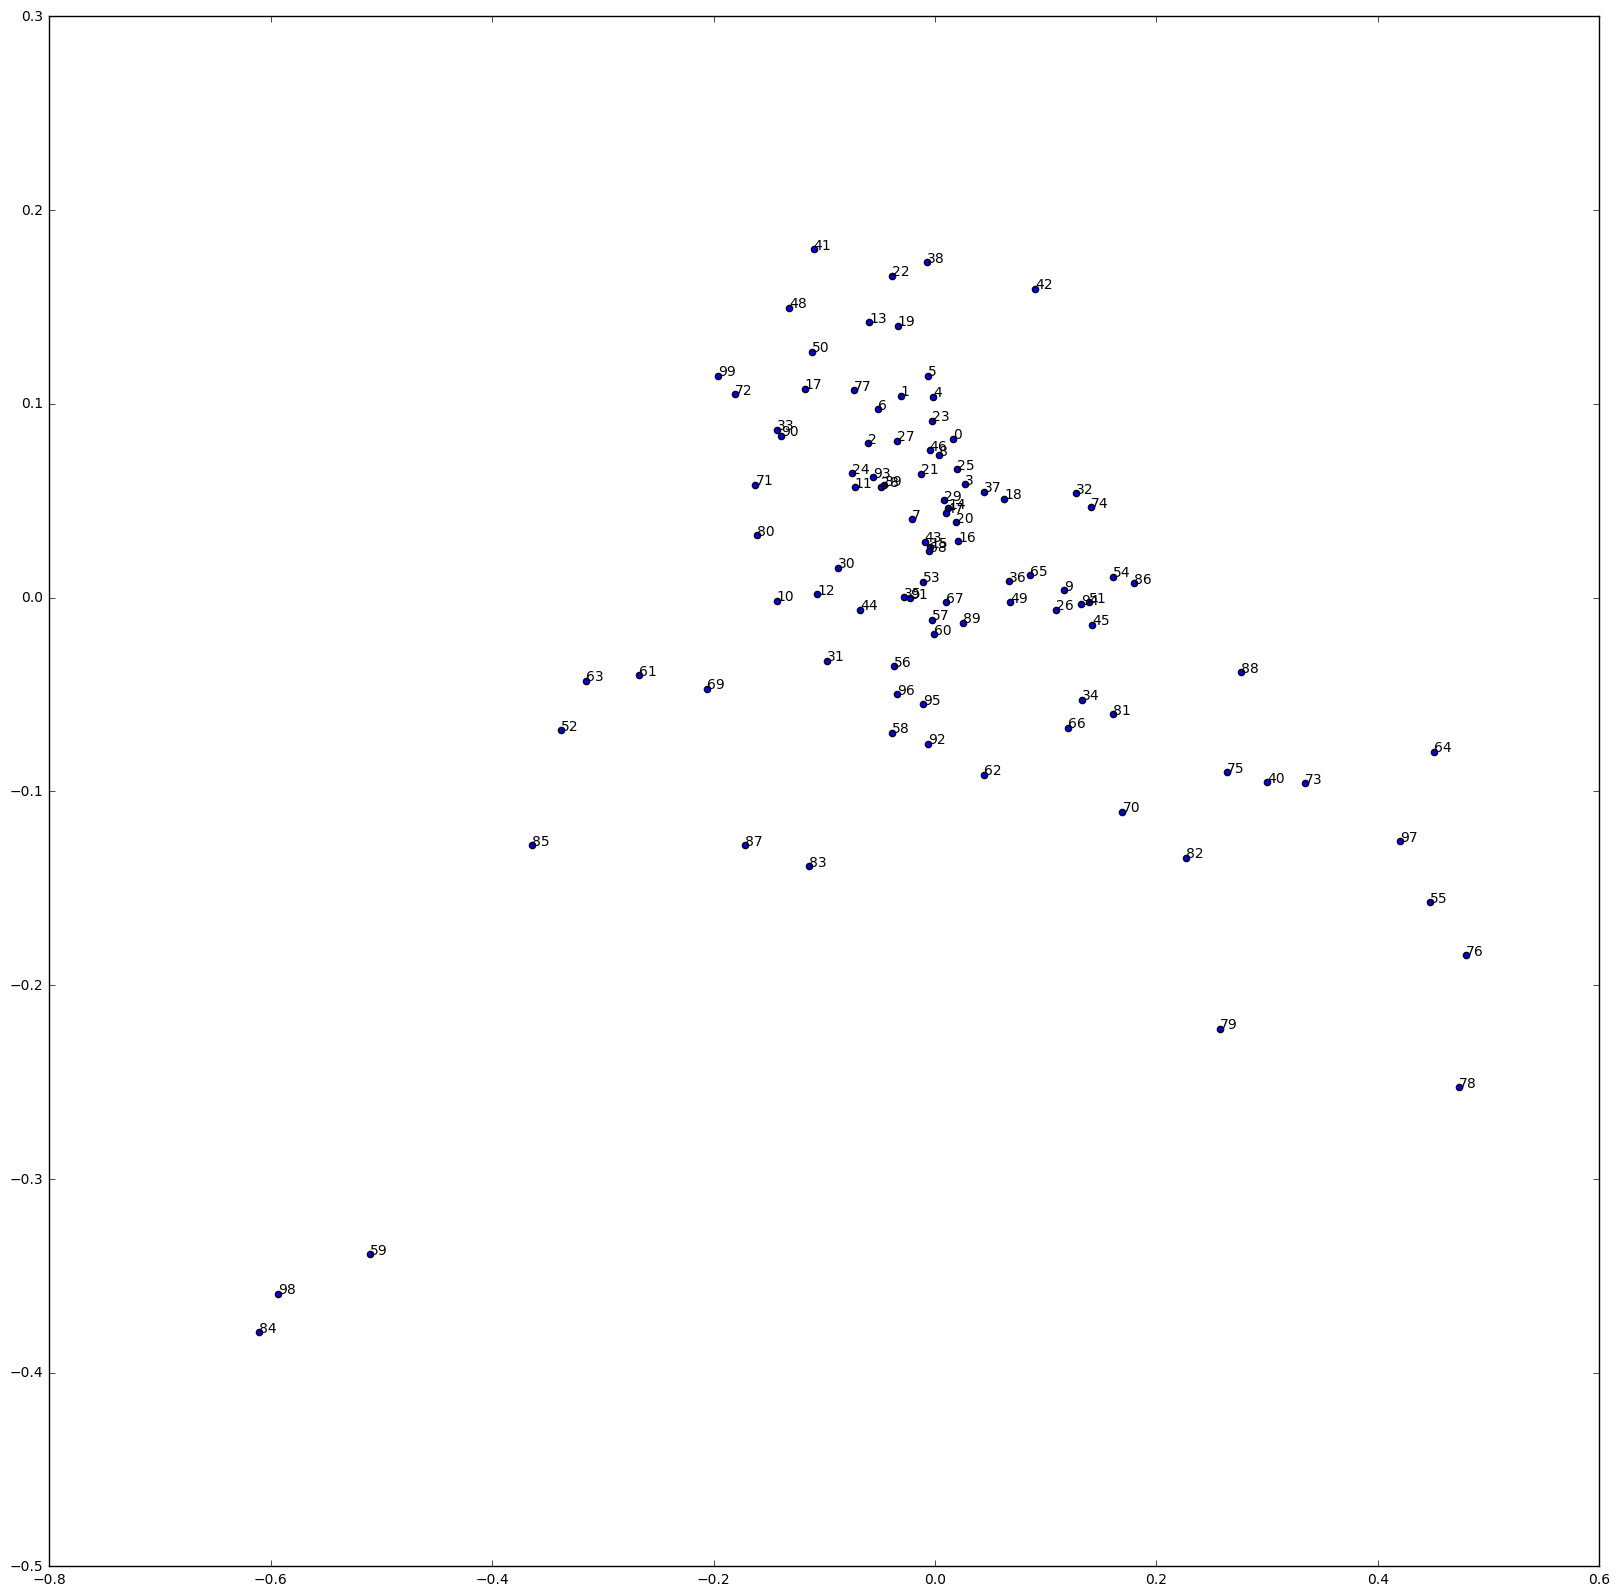

In [44]:
# Plotting the top 100 components using PCA.

X = motifs.head(100).values

from sklearn.decomposition import PCA
pca = PCA(2) # Reduce dimensionality down to 2.
Y = pca.fit_transform(X)

plt.figure(figsize=(20,20))
plt.scatter(Y[:,0], Y[:,1])
for ix, c in enumerate(Y):
    plt.annotate(xytext=c, xy=c, s=ix, )

### Inter-event Times (IETs)

In [45]:
teg_iets = get_ccdf(teg.get_iet_distribution())

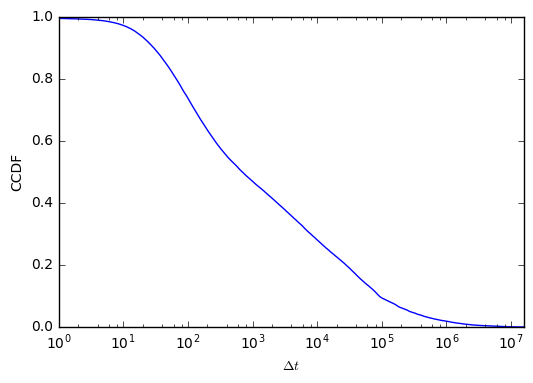

In [53]:
teg_iets.plot(logx=True)
plt.xlabel(r'$\Delta t$')
plt.ylabel(r'CCDF');

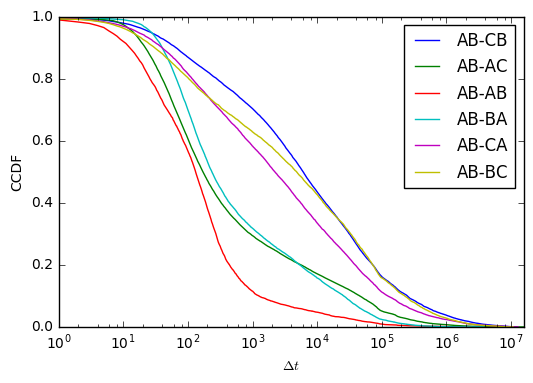

In [54]:
# Conditioned on the motif they form.

motif_iets = teg.get_iet_distribution(by_motif=True)

for motif, iets in motif_iets.items():
    ccdf = get_ccdf(iets)
    ccdf.plot(logx=True, logy=False, label=motif)
plt.legend(loc='best')
plt.xlabel(r'$\Delta t$')
plt.ylabel(r'CCDF');

### Entropy

In [55]:
def get_teg_metrics(component):
    """ Returns all metrics associated with the TEG. """
    
    iets = component.get_iet_distribution()
    motifs = component.get_motif_distribution()
    
    ccdf = get_ccdf(iets)
    y = [-x*np.log2(x) for x in ccdf if x > 0]
    from scipy.integrate import simps
    iet_entropy = simps(y, x=np.linspace(0,1,len(y)))
    
    motifs = {key: val/len(motifs) for key, val in Counter(motifs).items()}
    motif_entropy = sum([-x*np.log2(x) for x in motifs.values()])
    
    num_events = len(component.nodes())
    
    return iet_entropy, motif_entropy, iets, motifs, num_events

component_stats = {}
for ix, component in enumerate(components):
    if len(component) < 20:
        break
    iet_entropy, motif_entropy, _, motifs, num_events =  get_teg_metrics(component)
    component_stats[ix] = {'iet_entropy': iet_entropy,
                           'motif_entropy': motif_entropy,
                           'size': num_events}
    
component_stats = pd.DataFrame.from_dict(component_stats).T

In [56]:
component_stats.head()

,iet_entropy,motif_entropy,size
0,0.376478,2.486342,2030.0
1,0.383062,2.461286,1559.0
2,0.395685,2.400498,1463.0
3,0.379439,2.452609,1450.0
4,0.376541,2.477035,1406.0


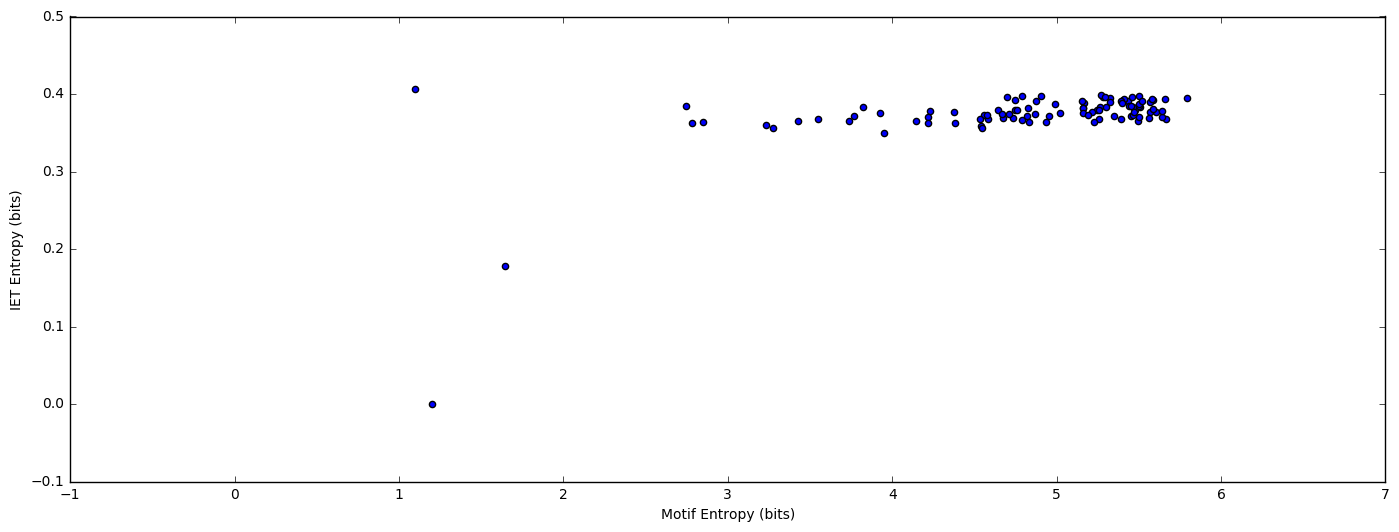

In [61]:
fig = plt.figure(figsize=(np.sqrt(2)*6*2,6))
ax = fig.add_subplot(111)

head = 100

component_stats.head(head).plot(kind='scatter', y='iet_entropy', x='motif_entropy', 
                                ax=ax, s=1*component_stats['size'][:10]*0.5,
                               alpha=0)

for x,y,ix in zip(component_stats.head(head)['motif_entropy'],
                  component_stats.head(head)['iet_entropy'],
                  component_stats.head(head).index):
    #plt.text(2**x,y,str(ix), fontsize=10) # Uncomment to add component labels.
    plt.scatter(2**x,y, alpha=1)

ax.set_xlabel(r'Motif Entropy (bits)')
ax.set_ylabel(r'IET Entropy (bits)');

### Drawing Individual Components

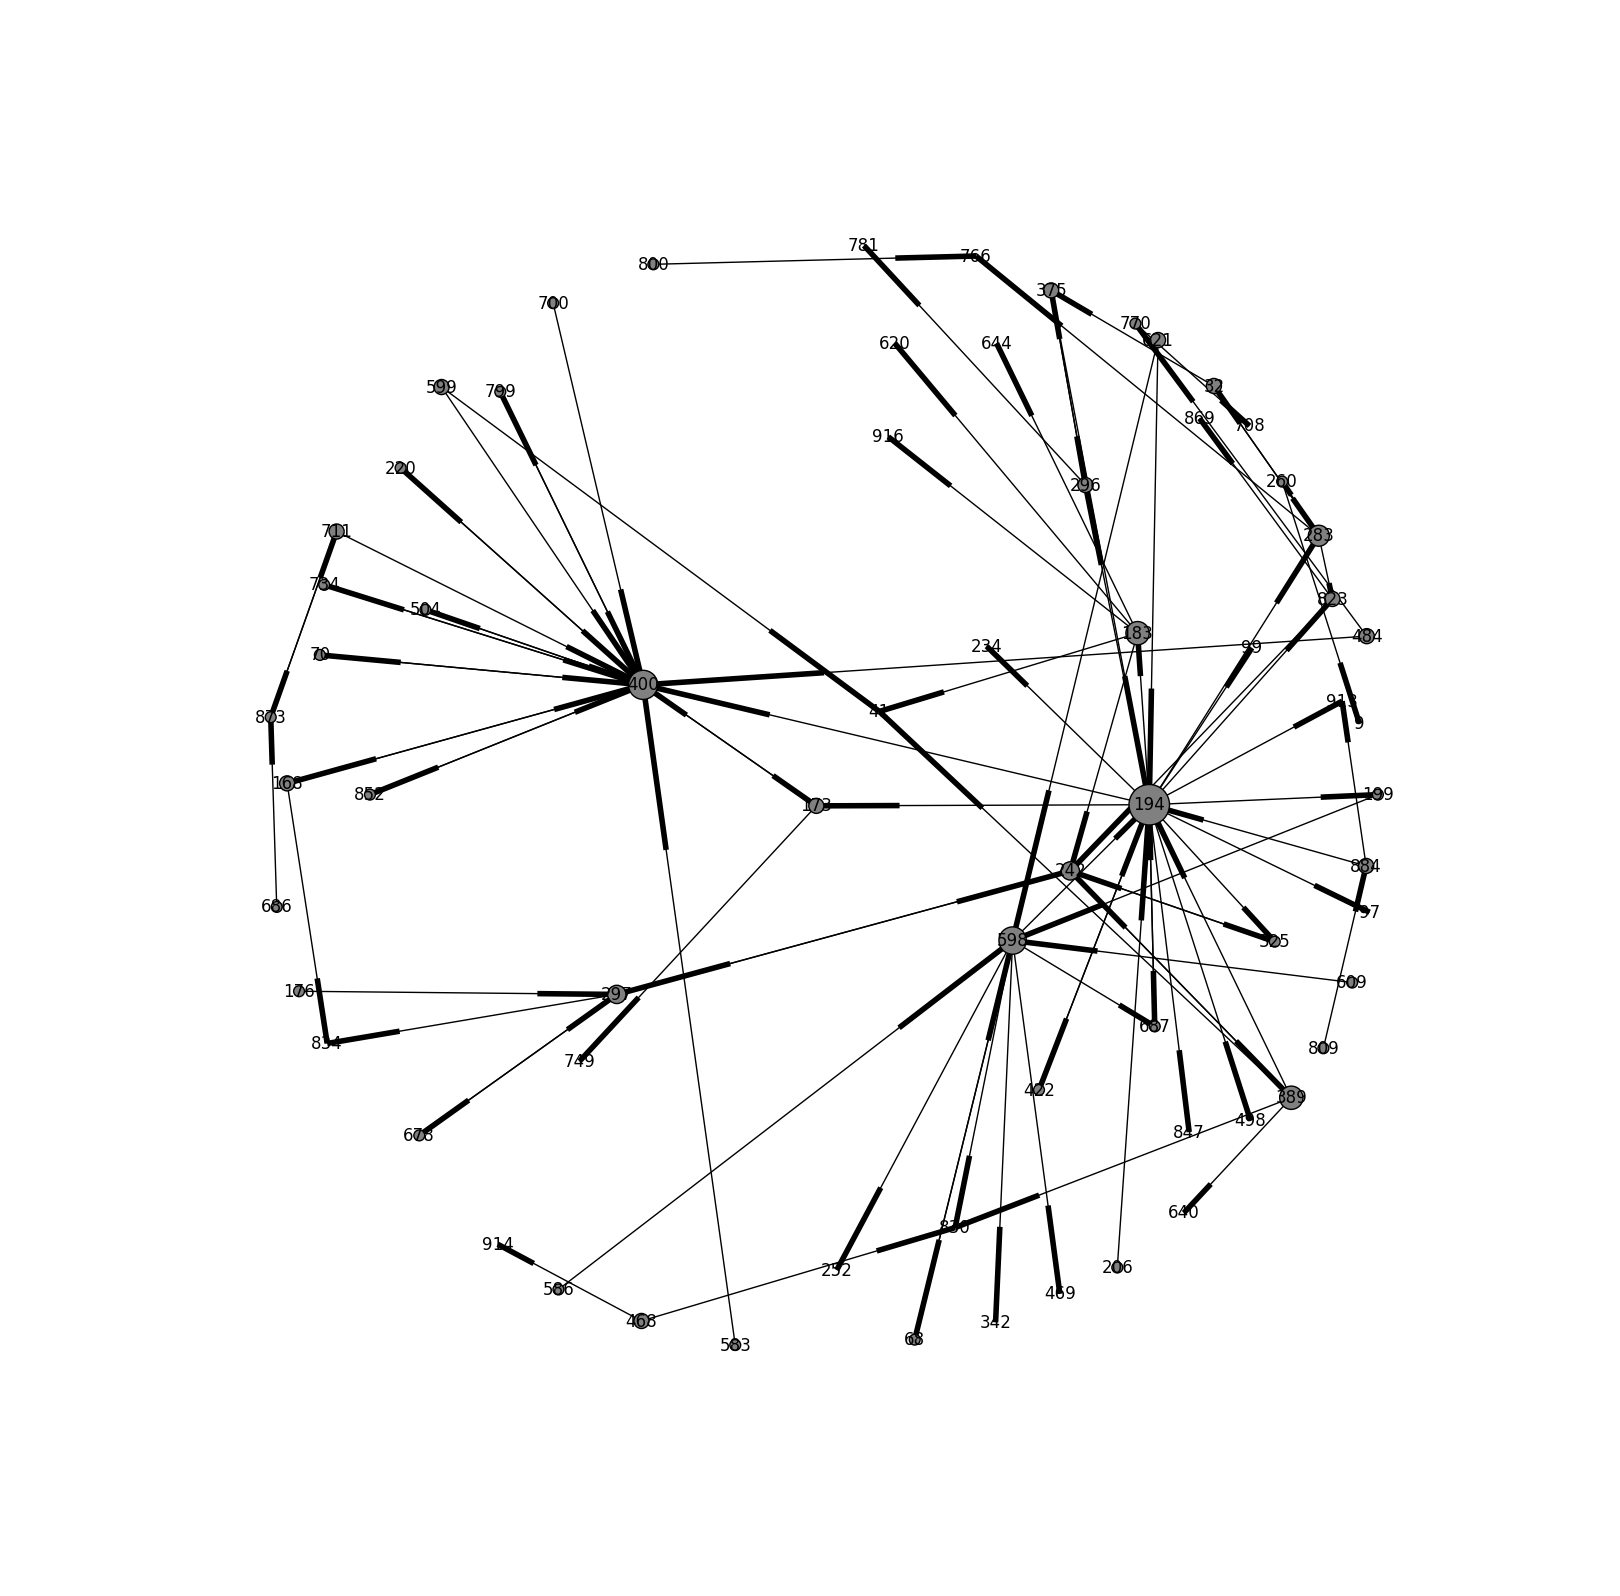

In [64]:
component_index=50

select_events = data.ix[components[component_index].nodes()]

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
G = nx.DiGraph()
G.add_edges_from(select_events[['source', 'target']].to_records(index=False))

d = nx.out_degree_centrality(G)
e = G.edges(data=True)

nx.draw_networkx(G, 
                 nodelist=d.keys(), 
                 node_size=[(v * 5000)**0.95 for v in d.values()], 
                 scaling=0.1, 
                 node_color='gray',) 
ax.set_axis_off()

### Decomposition Trees (Experimental)

In [15]:
dts = [3600, 60, 10]
tree = teg.build_tree(dts)

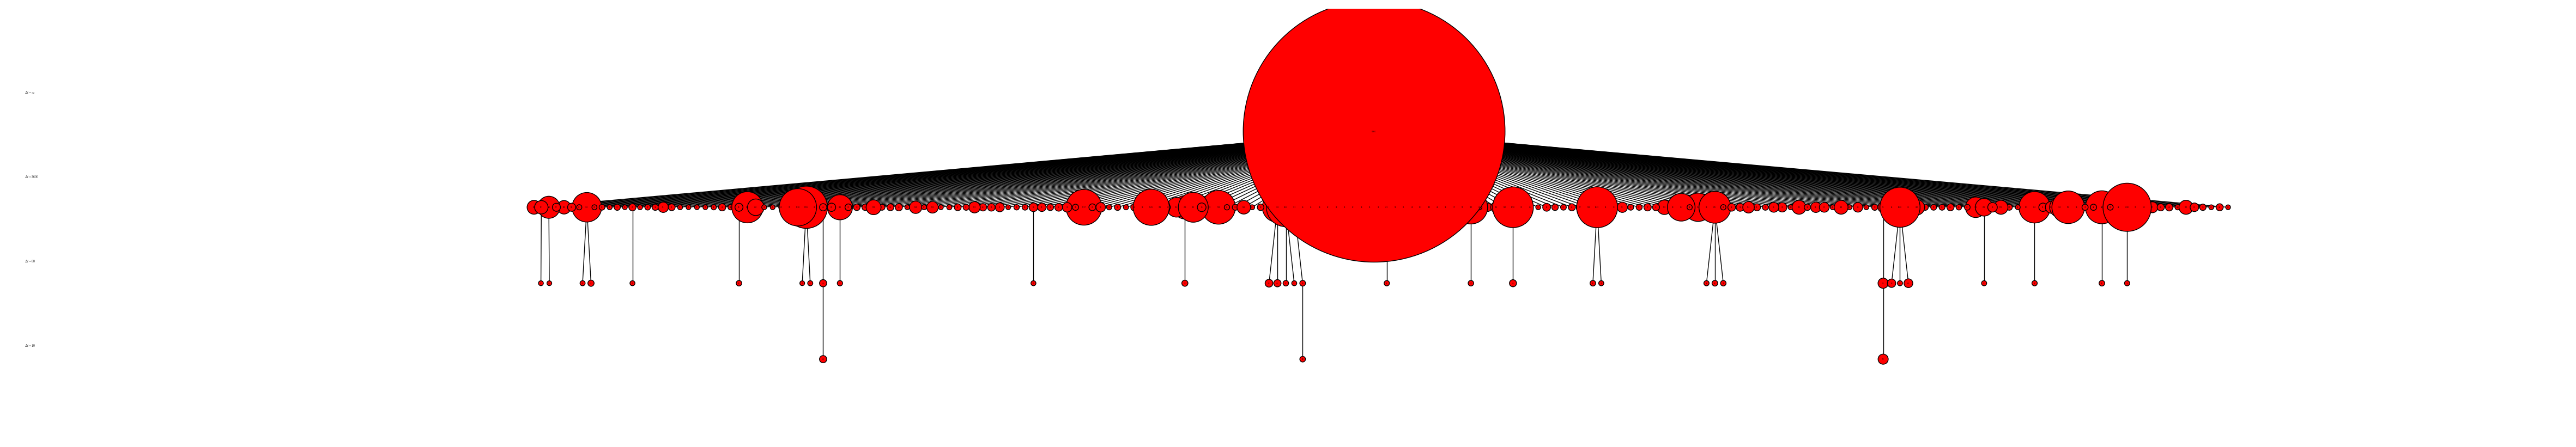

In [17]:
# This may take some time to draw, and the node scalings are currently off.
draw_tree(tree, figsize=(60,10), font_size=2, node_scale=2, dts=dts, min_size=20)